In [1]:
import os
#import numpy as np
import concurrent.futures
import re
from gensim.models import KeyedVectors
from gensim.models import FastText as fasttext
from gensim.test.utils import get_tmpfile
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import json
from PIL import Image
%pylab inline
#nltk.download("stopwords")

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Utility functions

#get magnitude of a vector
def length_of(vector):
        return math.sqrt(sum([e * e for e in vector])) #equivalent to np.linalg.norm() 2-norm

#calc cosine similarity between two vectors
def cosine_similarity(vec_src, vec_dst):
    dot_p = np.dot(vec_src,vec_dst)
    sm = dot_p/(length_of(vec_src) * length_of(vec_dst))
    return sm

def euclidean_distance(vec_src, vec_dst):
    return np.linalg.norm(vec_src - vec_dst)

#sort vector array by cosine similarity
def sort_by_cosine_similarity(vector, pool):
    sim = [cosine_similarity(vector, x) for x in pool]
    return [(index, value) for (index, value) in sorted(enumerate(sim), key=lambda k: k[1], reverse=True)]

In [3]:
class Vectors:
    def __init__(self, filename):
        self.vector_file = filename
        self.embedding_dict = None
        self.stop_words = set(stopwords.words('english'))
        return
        
    def load_word_vectors(self, mode='fasttext'):
        if self.embedding_dict is None:
            if mode.lower() == 'fasttext':
                print("load fasttext vec")
                self.embedding_dict = fasttext.load_fasttext_format(self.vector_file).wv
            else:
                print("load word2vec")
                self.embedding_dict = KeyedVectors.load_word2vec_format(self.vector_file) 
            ''' 
            Note that Fasttext bin file is not compatible with word2vec format as it contains extra 
            information for subwords that might be useful for dealing with out-of-vocabulary words. 
            
            Another solution to load FastText .vec if out-of-vocabulary words are not a concern
            Step 1. load .vec file. .vec file contains texts info for all words pretrained
            self.embedding_dict = KeyedVectors.load_word2vec_format(self.vector_file, binary=False) 
            Step 2. Convert .vec file into word2vec .bin format
            self.embedding_dict.save_word2vec_format(self.vector_file + ".bin", binary=True) 
            Step 3. Load converted .bin file. 
            self.embedding_dict = KeyedVectors.load_word2vec_format(self.vector_file + ".bin", binary=True)
            '''
            self.vector_size = self.embedding_dict.vector_size
        return self.embedding_dict
    
    #For experiment only
    def get_word_vector(self, words):
        wordvec = []
        try:
            wordvec = self.embedding_dict[words]
        except Exception as ex:
            for word in words:
                match_list = self.embedding_dict.most_similar(word)
                wordvec.append([key for (key, value) in match_list][0]) #return the most similar one
        return wordvec

    def get_sentence_vector(self, sentence, in_vocabulary=True):
        word_list = self._get_word_list(sentence)
        #skip out-of-vocabulary words
        if in_vocabulary:
            keywords = [word for word in word_list if word in self.embedding_dict.vocab]
        else:
            keywords = word_list
        
        mean_vec = np.mean(np.array(self.get_word_vector(keywords)), axis=0) if len(keywords) > 0 else np.ones(self.vector_size)
        
        return mean_vec
    
    def generate_sentence_vectors(self, sentence_list):
        sentence_vec = []
        for sent in sentence_list:
            sc = self.get_sentence_vector(sent)
            sentence_vec.append(sc)
        sentence_embedding = np.array(sentence_vec)
        return sentence_embedding     
    
    def _filter_stop_words(self, tokens):
        new_tokens = []
        for tk in tokens:
            if tk not in self.stop_words:
                new_tokens.append(tk)
        return new_tokens
        
    def _filter_numbers(self, tokens):
        tokens = [token for token in tokens if token.isalpha()]
        return tokens
    
    def _filter_punct(self, tokens):
        new_tokens = []
        for token in tokens:
            token = re.sub(r'[^\w\s]', ' ', token)
            if token:
                new_tokens.append(token)
        return new_tokens
        
    def _decontracted(self, text):
        # specific
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        # general
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"let\'s", "let us", text)
        return text
    
    def _prepare_text(self, text):
        text = text.lower()
        text = self._decontracted(text)
        return text
     
    def _normalize_tokens(self, tokens):
        tokens = self._filter_punct(tokens)
        tokens = self._filter_numbers(tokens)
        tokens = self._filter_stop_words(tokens)
        return tokens
    
    def _get_word_list(self, text):
        text = self._prepare_text(text)
        tokens = text.split(' ')
        tokens = self._normalize_tokens(tokens)
        return tokens
    
    def find_nearest_neighbour(self, vec_sentence, vec_pool):
        neighbours = sort_by_cosine_similarity(vec_sentence, vec_pool)
        return neighbours

In [4]:
%%time
'''
Experiments with different pretrained vectors
    1. trained on life is strange (loading time 161ms): ./lifeisstrange.vec 
    2. subword vectors (loading time 22.6s): ./fasttext/pretrained/wiki-news-300d-1M-subword.vec 
    3. trained on whole corpus of wiki.en: ./fasttext/pretrained/wiki.en/wiki.en.vec 
'''
model1 = './data source/lifeisstrange'
model2 = './fasttext/pretrained/wiki-news-300d-1M-subword.vec'
model3 = './fasttext/pretrained/wiki.en/wiki.en'

word_embeddings = Vectors(model3)
word_embeddings.load_word_vectors(mode='fasttext');

load fasttext vec
CPU times: user 6min 3s, sys: 1min 1s, total: 7min 4s
Wall time: 8min 41s


In [ ]:
#get sentence vectors (image keywords not included)
'''sentence_list = []
ind_dict = dict()
sentence_id = 0
with open('./data source/Life Is Strange 1/output 1/Life Is Strange.json', 'r') as f:
    #database = json.load()
    json_str = f.read()
    database = json.loads(json_str)
    for caps in database:
        file_idx = caps['file_index']
        cap_list = caps['captions']['cc_info']
        for cap in cap_list:
            cap_text = cap['text']
            sentence_list.append(cap_text)
            ind_dict[sentence_id] = (file_idx, cap['session_id'])
            sentence_id += 1
            
#sentence_embedding only uses in-vocabulary words            
sentence_vectors = word_embeddings.generate_sentence_vectors(sentence_list) 
np.save('sentence_emb', np.array(sentence_vectors))
'''

In [5]:
#get sentence vectors (image keywords included)
sentence_list = []
ind_dict = dict()
sentence_id = 0
database_file = './data source/Life Is Strange 1/output 1/lifeisstrange_w_img_top3keywords.json'
with open(database_file, 'r') as f:
    json_str = f.read()
    database = json.loads(json_str)
    for caps in database:
        file_idx = caps['file_index']
        session_lst = caps['screenshots']['image_info']
        for session in session_lst:
            cap_text = session['caption']
            session_id = session['session_id']
            for frame_id, frame_info in session['frames'].items():
                frame_keywords = ''
                if 'image_keywords' in frame_info.keys():
                    frame_keywords = frame_info['image_keywords']
                    frame_keywords = frame_keywords.replace('_', ' ')
                    
                sentence_list.append(' '.join([cap_text, frame_keywords]))
                ind_dict[sentence_id] = (file_idx, session_id, frame_id)
                sentence_id += 1
print(len(ind_dict.keys()))    
print(len(sentence_list))
#sentence_embedding only uses in-vocabulary words            
sentence_vectors = word_embeddings.generate_sentence_vectors(sentence_list) 
embedding_file = database_file[:database_file.rfind('.json')]
np.save(embedding_file, np.array(sentence_vectors))

with open(embedding_file + '_emb.json', 'w') as outfile:
    json.dump(ind_dict, outfile, sort_keys=False, indent=4)

15472
15472


In [6]:
# Moving average
def moving_average(data, window_size):
    ma = []
    half = int((window_size - 1) / 2)
    for n in range(len(data)):
        start = n - half
        stop = start + window_size 
        if start < 0:
            start = 0
        elif stop > len(data) :
            stop = len(data)
            
        ma.append(np.mean(data[start: stop], axis = 0))
    return np.array(ma)

sentence_vec_filtered = moving_average(sentence_vectors, 10)


User Inquiry: deduction scene


FileNotFoundError: [Errno 2] No such file or directory: './Movies/Life Is Strange 1/output 1/Life is Strange - Season 1 Episode 2 Out of Time (Full Episode) (No Music)-24bX2r6KhV4/Frame_00198026.jpg'

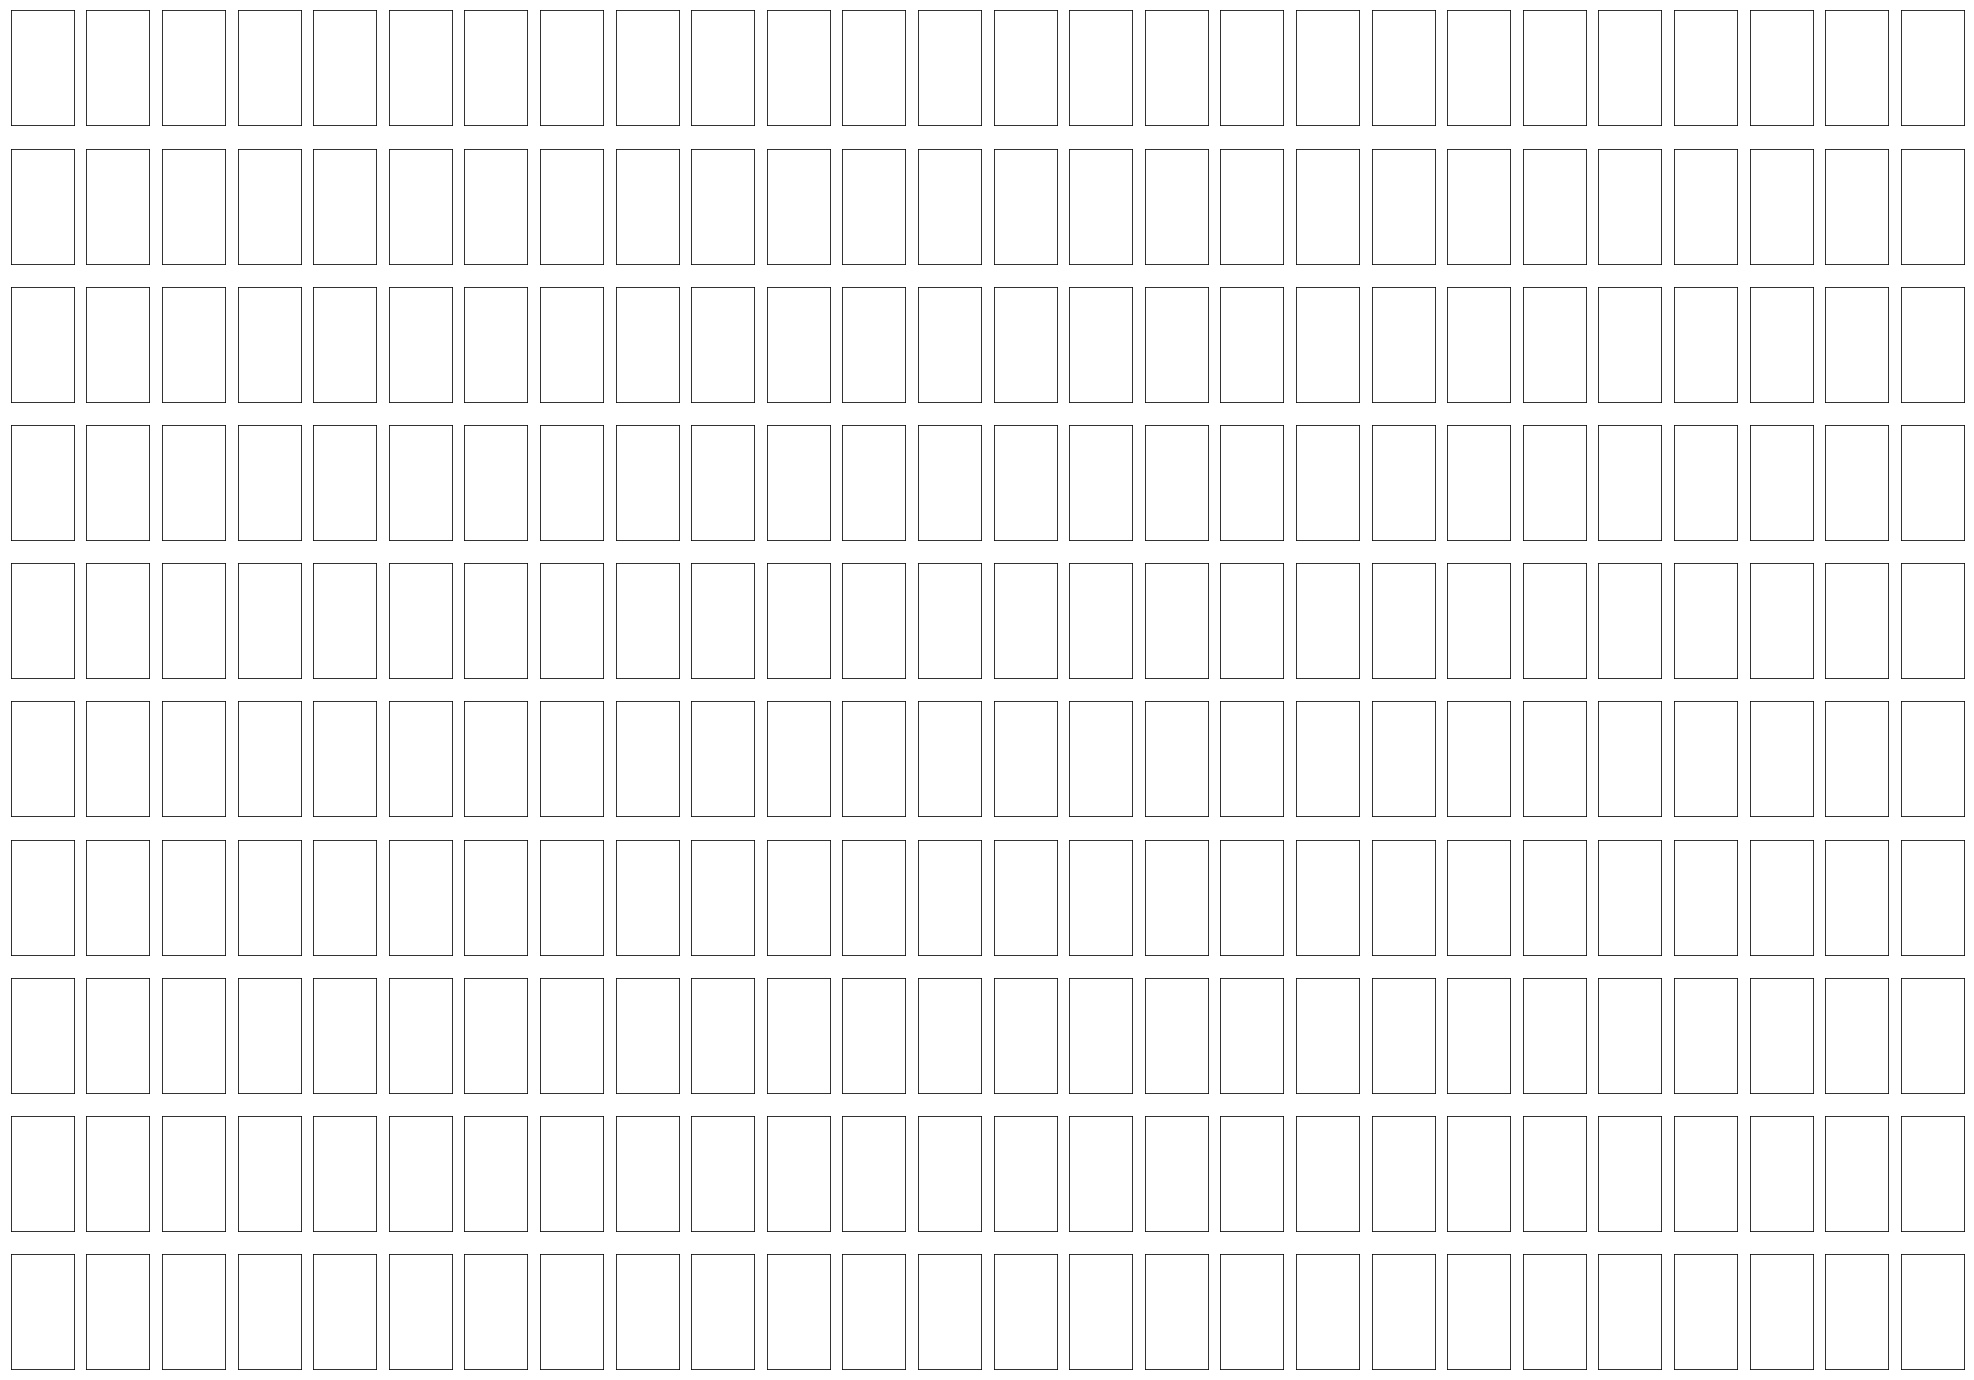

In [7]:
%%time
'''
Testcase 1: Finding the most relevant sentences given a source sentence
Some existing dialogues from database
    1. don't you remember what it's like to be a teenager
    2. kill me if she knew I was out there
    3. mom's old engagement ring supposed to be
    
Testcase 2: Finding the most relevant sentences given a random combination of words
    1. gun run mom
    
Testcase 3: try to find most similar words if words inquired are not in the vocabulary
''' 
top_n_neighbours = 10
#vec_pool = sentence_vectors
vec_pool = sentence_vec_filtered
result_file = database_file[:database_file.rfind('.json')] + '_results_ma10.json'
answer_file = './data source/Life Is Strange 1/output 1/correct_answers.json'

answer_database = json.loads(open(answer_file).read())
sentence_dir = answer_database.keys()
#sentence_dir = ["storm cliff tornado"]

file_results = open(result_file, 'w+')
#file_results.seek(0)
result_str = file_results.read()
if len(result_str) > 0:
    result_data = json.loads(result_str)
else:
    result_data = {}
#file_results.truncate(0)


if len(sentence_dir) > 1:
    fig, axes = plt.subplots(top_n_neighbours, len(sentence_dir), figsize=(35, 25), subplot_kw={'xticks': [], 'yticks': []})

src_sentence_id = 0
for src_sentence in sentence_dir:
    vec_sen = word_embeddings.get_sentence_vector(src_sentence, in_vocabulary = True) #get similar vectors, only used for bin
    neighbours = word_embeddings.find_nearest_neighbour(vec_sen, vec_pool)
    print(f'User Inquiry: {src_sentence}')
#     with open(result_file, 'a+') as file_rst:
#         file_rst.seek(0)
#         result_str = file_rst.read()
#         if len(result_str) > 0:
#             result_data = json.loads(result_str)
#         else:
#             result_data = {}

#         file_rst.truncate(0)

    result_data[src_sentence] = []
    top_n = 0
    for (nb_id, distance) in neighbours[:top_n_neighbours]:
        file_id = ind_dict[nb_id][0]
        session_id = ind_dict[nb_id][1]
        key = ind_dict[nb_id][2]
        folder = database[file_id]['screenshots']['image_folder']
        sessions = database[file_id]['screenshots']['image_info']

        cap_text = sessions[session_id]['caption']
        img_file = sessions[session_id]['frames'][key]['image_file']
        img_keyword = ''
        if 'image_keywords' in sessions[session_id]['frames'][key].keys():
            img_keyword = sessions[session_id]['frames'][key]['image_keywords']

        result_data[src_sentence].append({'file':file_id, 'cap':session_id, 'text': cap_text, 'frame_id': key, 'keywords': img_keyword})

        img_file = os.path.join(folder, img_file)
        image = Image.open(img_file) 
        title = f'{file_id}:{key}'
        if len(sentence_dir) > 1:
            axes[top_n][src_sentence_id].imshow(np.asarray(image))
            axes[top_n][src_sentence_id].set_title(title)
        else:
            plt.figure()
            plt.imshow(image)

        top_n += 1
    src_sentence_id += 1
print(result_data[src_sentence])
json.dump(result_data, file_results, indent=4)
file_results.close()
        
if len(sentence_dir) > 1:
    fig.tight_layout()       
    plt.show()